In [21]:
from __future__ import print_function
import numpy as np
from six.moves import cPickle as pickle
import tensorflow as tf
from tensorflow.python.client import timeline

import time
import matplotlib.pyplot as plt
%matplotlib inline

print("import done")

import done


#### Load pickled dataset into memory

In [22]:
name_pickle = './data/trainsh1.pickle'

with open(name_pickle, 'rb') as f:
    print('Unpickling ' + name_pickle)
    load = pickle.load(f)
    dataset = load['data']
    labels = load['labels']
    del load
    print('dataset shape:', dataset.shape)
    print('labels shape:', labels.shape)

Unpickling ./data/trainsh1.pickle
dataset shape: (30, 240000, 16)
labels shape: (30,)


#### Reformat data for training
- Divide each file with 240000 samples into smaller batch_samples ~= size of receptive field of eegnet
- Keep valid_dataset nr of samples intact for proper validation

In [23]:
def normalize_array(array):
    # Normalize mean=0 and sigma=0.25: axis=0 is along columns, vertical lines.
    array -= np.mean(array, axis=0) 
    array /= 2*np.ptp(array, axis=0)
    return array
    
def clean_normalize_data_labels(data, labels, sigma=0.5):
    data_tmp = list()
    labels_tmp = list()
    for idx, d in enumerate(data):
        if (np.count_nonzero(d) < 10) or (np.any(np.std(d, axis=0) < sigma)):
            continue
        d = normalize_array(d)
        data_tmp.append(d)
        labels_tmp.append(labels[idx])
    return np.asarray(data_tmp), np.asarray(labels_tmp)

In [24]:
#Output size of the layer
num_labels = 2

#60% for train and 40% for validation
split_idx = int(dataset.shape[0]*0.8)
#nr of splits
nrOfSplits = 100

def format_data(data, labels, nr_splits):
    shape = data.shape
    # reshape [batch, samples, channels] into [batch * samples, channels]
    data = np.reshape(data, (shape[0]*shape[1], shape[2]))
    # Split 2D array into the desired smaller chuncks
    data = np.asarray(np.split(data, shape[0]*nr_splits, axis=0))
    # labels are obtained by repeating original labels nr_splits times
    labels = np.repeat((np.arange(num_labels) == labels[:,None]).astype(np.float32), nr_splits, axis=0)
    # normalize and eliminate batches that only contain drop-outs
    data, labels = clean_normalize_data_labels(data, labels, 0.01)
    # data has to be 4D for tensorflow (insert an empty dimension)
    data = data[:,None,:,:]
    # shuffle data and labels mantaining relation between them. Important after the small batches.
    shuffle_idx = np.random.permutation(data.shape[0])
    data = data[shuffle_idx,:,:,:]
    labels = labels[shuffle_idx]
    return data, labels

# shuffle file data
shuffle_idx = np.random.permutation(dataset.shape[0])
dataset = dataset[shuffle_idx,:,:]
labels = labels[shuffle_idx]
# format and split data into smaller chunks
train_dataset, train_labels = format_data(dataset[:split_idx], labels[:split_idx], nrOfSplits)
valid_dataset, valid_labels = format_data(dataset[split_idx:-1], labels[split_idx:-1], nrOfSplits)
del dataset, labels

valid_dataset = valid_dataset[:200]
valid_labels = valid_labels[:200]

print('train_dataset shape:', train_dataset.shape, 'train_labels shape:', train_labels.shape, 
      'mix:', float(np.count_nonzero(train_labels[:,1], axis=0))/train_labels.shape[0])
print('valid_dataset shape:', valid_dataset.shape, 'valid_labels shape:', valid_labels.shape, 
      'mix:', float(np.count_nonzero(valid_labels[:,1], axis=0))/valid_labels.shape[0])

train_dataset shape: (1920, 1, 2400, 16) train_labels shape: (1920, 2) mix: 0.5828125
valid_dataset shape: (200, 1, 2400, 16) valid_labels shape: (200, 2) mix: 0.215


#### Plot some data to have an idea of how data looks like

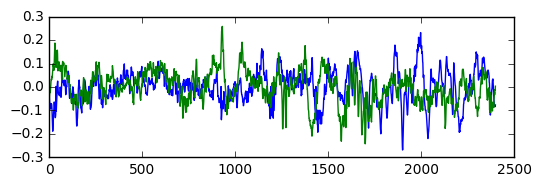

In [25]:
plt.subplot(211)
plt.plot(train_dataset[1,0,:,0])
plt.plot(train_dataset[3,0,:,0])

## EEGNET implementation

Part of https://arxiv.org/pdf/1609.03499.pdf that most concerns classification:
"As a last experiment we looked at speech recognition with WaveNets on the TIMIT (Garofolo et al., 1993) dataset. For this task we added a mean-pooling layer after the dilation convolutions that aggregated the activations to coarser frames spanning 10 milliseconds (160 x downsampling). The pooling layer was followed by a few non-causal convolutions. We trained WaveNet with two loss terms, one to predict the next sample and one to classify the frame, the model generalized better than with a single loss and achieved 18.8 PER on the test set, which is to our knowledge the best score obtained from a model trained directly on raw audio on TIMIT."

Look into: http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43290.pdf
"Input: This layer extracts 275 ms waveform segments from each of M input microphones. Successive inputs are hopped by 10ms. At the 16kHz sampling rate used in our experiments each segment contains M X 4401 dimensions."
....

In [27]:
#How many files are supplied per batch.
batch_size=16
#Number of samples in each batch entry
batch_samples=train_dataset.shape[2]
#How many filters to learn for the input.
input_channels=16
#How many filters to learn for the residual.
residual_channels=2*input_channels
# size after pooling layer
pool_size = 2400
#number of steps after which learning rate is decayed
decay_steps=500

filter_width=3

slim = tf.contrib.slim

#Construct computation graph
graph = tf.Graph()

with graph.as_default():
    
    # Input data
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, 1, batch_samples, input_channels))
    tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset, dtype=tf.float32)
    tf_valid_labels = tf.constant(valid_labels, dtype=tf.int32)
    
    def network(batch_data, reuse=False, is_training=True):
        with tf.variable_scope('eegnet_network', reuse=reuse):
            with slim.arg_scope([slim.batch_norm], 
                                is_training=is_training):
                with slim.arg_scope([slim.conv2d, slim.fully_connected], 
                                    weights_initializer=slim.xavier_initializer(), 
                                    normalizer_fn=slim.batch_norm):
                    with tf.variable_scope('input_layer'):
                        hidden = slim.conv2d(batch_data, residual_channels, [1, filter_width], stride=1, rate=1, 
                                             activation_fn=None, scope='conv1')

                    with tf.variable_scope('hidden'):
                        with tf.variable_scope('layer1'):
                            layer_input = hidden
                            hidden = slim.conv2d(hidden, 2*residual_channels, [1, filter_width], stride=1, rate=2, 
                                                 activation_fn=None, scope='dilconv')
                            filtr, gate = tf.split(3, 2, hidden) # split features in half
                            hidden = tf.mul(tf.tanh(filtr), tf.sigmoid(gate), name='filterXgate')
                            hidden = slim.conv2d(hidden, residual_channels, 1, activation_fn=None, scope='1x1skip')
                            skip = hidden # skip conn
                            hidden = tf.add(hidden, layer_input) # residual conn
                        with tf.variable_scope('layer2'):
                            layer_input = hidden
                            hidden = slim.conv2d(hidden, 2*residual_channels, [1, filter_width], stride=1, rate=4, 
                                                 activation_fn=None, scope='dilconv')
                            filtr, gate = tf.split(3, 2, hidden) # split features in half
                            hidden = tf.mul(tf.tanh(filtr), tf.sigmoid(gate), name='filterXgate')
                            hidden = slim.conv2d(hidden, residual_channels, 1, activation_fn=None, scope='1x1skip')
                            skip = tf.add(skip, hidden) # skip conn
                            hidden = tf.add(hidden, layer_input) # residual conn
                        with tf.variable_scope('layer3'):
                            hidden = slim.conv2d(hidden, 2*residual_channels, [1, filter_width], stride=1, rate=8, 
                                                 activation_fn=None, scope='dilconv')
                            filtr, gate = tf.split(3, 2, hidden) # split features in half
                            hidden = tf.mul(tf.tanh(filtr), tf.sigmoid(gate), name='filterXgate')
                            hidden = slim.conv2d(hidden, residual_channels, 1, activation_fn=None, scope='1x1skip')
                            skip = tf.add(skip, hidden) # skip conn
                        
                    with tf.variable_scope('skip_processing'):
                        hidden = tf.nn.relu(skip)
                        hidden = slim.avg_pool2d(hidden, [1, batch_samples*2//pool_size], [1, batch_samples//pool_size])
                        # 1 x 2400 x residual_channels
                        hidden = slim.conv2d(hidden, 32, 1, activation_fn=tf.nn.relu, scope='1x1compress1')
                        hidden = slim.conv2d(hidden, 16, [1, 8], stride=4, activation_fn=tf.nn.relu, scope='1x5reduce1')
                        # 1 x 600 x 16
                        hidden = slim.conv2d(hidden, 8, 1, activation_fn=tf.nn.relu, scope='1x1compress2')
                        hidden = slim.conv2d(hidden, 4, [1, 8], stride=4, activation_fn=tf.nn.relu, scope='1x5reduce2')
                        # 1 x 150 x 4
                        hidden = slim.conv2d(hidden, 2, 1, activation_fn=tf.nn.relu, scope='1x1compress3')
                        hidden = slim.conv2d(hidden, 2, [1, 6], stride=3, activation_fn=tf.nn.relu, scope='1x5reduce3')
                        # 1 x 75 x 2

                    with tf.variable_scope('logits'):
                        hidden = slim.dropout(hidden, 0.7, is_training=is_training)
                        hidden = slim.flatten(hidden)
                        logits = slim.fully_connected(hidden, num_labels, activation_fn=None, 
                                                      normalizer_fn=None, scope='fc1')
        return logits 

    with tf.name_scope('eegnet_handling'):
        logits = network(tf_train_dataset)
        loss = slim.losses.softmax_cross_entropy(logits, tf_train_labels, scope='loss')
        tf.scalar_summary('loss', loss)
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-3, epsilon=1e-4).minimize(loss, 
                                                                                      var_list=tf.trainable_variables())
        train_probabilities = tf.nn.softmax(logits)
        train_predictions = tf.one_hot(tf.argmax(train_probabilities, 1), num_labels, dtype=tf.int32)
        train_accuracy = slim.metrics.accuracy(train_predictions, tf_train_labels, 100.0)
        valid_probabilities = tf.nn.softmax(network(tf_valid_dataset, True, False))
        valid_predictions = tf.one_hot(tf.argmax(valid_probabilities, 1), num_labels, dtype=tf.int32)
        valid_accuracy = slim.metrics.accuracy(valid_predictions, tf_valid_labels, 100.0)

    # Add histograms for trainable variables.
    for var in tf.trainable_variables():
        tf.histogram_summary(var.op.name, var)
        
    # Add summaries for activations: NOT WORKING YET. TF ERROR.
    #slim.summarize_activations()
    
    #Merge all summaries and write to a folder
    merged_summs = tf.merge_all_summaries()
    results_writer = tf.train.SummaryWriter('./results', graph)
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()
    
    #tracing for timeline
    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
    run_metadata = tf.RunMetadata()    
    
print('computational graph created')

computational graph created


In [ ]:
num_steps = 10001

trace_file = open('./tracing/timeline.json', 'w')
save_path = './checkpoints/model.ckpt'

best_loss = 99.0
val_accu = 0.0
best_val_accu = 0.0

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    tf.initialize_local_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, trprob, traccu, summary = session.run(
            [optimizer, loss, train_probabilities, train_accuracy, merged_summs], 
            feed_dict=feed_dict)
        results_writer.add_summary(summary, step)
        if (step % 13 == 0):
            best_loss = l if l < best_loss else best_loss
            print('Minibatch total loss at step %d: %f' % (step, l), '| Best:', best_loss)
            print('Minibatch accuracy:', traccu)
            print('Predictions | Labels:\n', np.concatenate((trprob[:2], batch_labels[:2]), axis=1))
        if (step % 50 == 0):
            val_accu = valid_accuracy.eval()
            best_val_accu = val_accu if val_accu > best_val_accu else best_val_accu
            print('###-> Validation accuracy:', val_accu, '| Best:', best_val_accu)
            
    # Save tracing into disl
    #trace = timeline.Timeline(step_stats=run_metadata.step_stats)
    #trace_file.write(trace.generate_chrome_trace_format(show_memory=True))
            
    # Save the variables to disk.
    saver.save(session, save_path)
    print("Model saved in file: %s" % save_path)
            
    results_writer.flush()
    results_writer.close()

    print('Finished training')

Initialized
Minibatch total loss at step 0: 0.612041 | Best: 0.612041
Minibatch accuracy: 56.25
Predictions | Labels:
 [[ 0.37404463  0.62595534  0.          1.        ]
 [ 0.49554217  0.50445783  1.          0.        ]]
###-> Validation accuracy: 21.5 | Best: 21.5
Minibatch total loss at step 13: 0.664518 | Best: 0.612041
Minibatch accuracy: 62.5
Predictions | Labels:
 [[ 0.39868829  0.60131168  0.          1.        ]
 [ 0.7300756   0.26992446  0.          1.        ]]
Minibatch total loss at step 26: 1.093468 | Best: 0.612041
Minibatch accuracy: 37.5
Predictions | Labels:
 [[ 0.41777068  0.58222938  1.          0.        ]
 [ 0.21997815  0.78002191  1.          0.        ]]
Minibatch total loss at step 39: 0.652846 | Best: 0.612041
Minibatch accuracy: 62.5
Predictions | Labels:
 [[ 0.52835995  0.47164002  1.          0.        ]
 [ 0.51308364  0.4869163   0.          1.        ]]
###-> Validation accuracy: 21.5 | Best: 21.5
Minibatch total loss at step 52: 0.646210 | Best: 0.612041

## Evaluate Model

In [ ]:
valid_batch_size = 1

def accuracy_notpercent(predictions, labels):
  return np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))

with tf.Session(graph=graph) as session:
    saver.restore(session, save_path)
    print('Model Loaded')
    data_split = np.array_split(valid_dataset, valid_dataset.shape[0]//valid_batch_size, axis=0)
    labels_split = np.array_split(valid_labels, valid_labels.shape[0]//valid_batch_size, axis=0)
    correct_predictions = 0
    for idx, batch_data in enumerate(data_split):
        correct_predictions += accuracy_notpercent(
            train_prediction.eval(feed_dict={tf_train_dataset: batch_data}), 
            labels_split[idx])
        print('accuracy:', (100.0*correct_predictions)/((idx+1)*valid_batch_size))
        
        
    print('Finished validation')